### Project 2: Predicting Student Failure 
#### David Pahmer

##### Prepping the Data

In [26]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
df=pd.read_excel('student_data_for_study.xlsx')

Let's clean up the majors: applied and graduated. Change the number 0 to UND.

In [27]:
df.shape

(15657, 20)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15657 entries, 0 to 15656
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          15657 non-null  int64  
 1   Major           15657 non-null  object 
 2   completed       15657 non-null  int64  
 3   grantpct        15657 non-null  int64  
 4   transfer        15657 non-null  int64  
 5   gpa_final       15643 non-null  float64
 6   gpa_first_term  15643 non-null  float64
 7   gpa_first_year  15643 non-null  float64
 8   cityapp         15568 non-null  object 
 9   statapp         14817 non-null  object 
 10  natnapp         1394 non-null   object 
 11  hscity          14776 non-null  object 
 12  hsstate         14159 non-null  object 
 13  hsnatn          1130 non-null   object 
 14  hsgpa           14876 non-null  object 
 15  minor           15657 non-null  int64  
 16  maj2            15657 non-null  int64  
 17  ethnicity       15657 non-null 

In [29]:
df.loc[df['Major']==0,'Major']="UND"
df.loc[df['Major']=='0000','Major']="UND"

Now, instead of treating each city as its own, let's create a feature called popular city which flags whether their home when applied is popular or unpopular, since that might be meaningful in our context.

In [30]:
popcities=df.cityapp.value_counts()[df.cityapp.value_counts().values>50].index.values

In [31]:
popcities

array(['Teaneck', 'Brooklyn', 'Woodmere', 'Los Angeles', 'Great Neck',
       'New York', 'Lawrence', 'West Hempstead', 'Flushing', 'Baltimore',
       'Silver Spring', 'Chicago', 'Skokie', 'Monsey', 'Boca Raton',
       'Englewood', 'West Orange', 'Bergenfield', 'Thornhill',
       'Staten Island', 'Cedarhurst', 'Edison', 'Fair Lawn',
       'Highland Park', 'Bronx', 'Toronto', 'New Rochelle', 'Hollywood',
       'Montreal', 'Houston', 'Passaic', 'Miami Beach', 'Beachwood',
       'Miami', 'Elizabeth', 'Suffern', 'Pittsburgh', 'Atlanta',
       'Lincolnwood', 'Jamaica', 'Southfield', 'Valley Village',
       'East Brunswick', 'Seattle', 'Spring Valley', 'Beverly Hills',
       'North Miami Beach', 'Memphis', 'Columbus', 'Casablanca', 'Panama',
       'Bala Cynwyd', 'Philadelphia', 'Sharon', 'Newton', 'Dallas',
       'Oceanside', 'Brookline', 'Far Rockaway', 'Plainview', 'Denver',
       'Scarsdale', 'Livingston'], dtype=object)

In [32]:
df['pop_city']=df['cityapp'].isin(popcities).astype(int)

In [33]:
df.pop_city.value_counts()

1    11542
0     4115
Name: pop_city, dtype: int64

So most people are from cities where at least 50 people have applied.

Let's see if gender is abnormal:

In [34]:
df.Gender.value_counts()

1    8270
2    7387
Name: Gender, dtype: int64

It looks normal (not in the technical, statistics sense).  

Having created a popular city field from the actual city field, we can drop city.

In [35]:
df=df.drop(columns='cityapp')

Let's see the story with international applicants:

In [36]:
df.natnapp.value_counts()

CANADA                        644
ISRAEL                        175
FRANCE                        119
MOROCCO                        82
PANAMA                         82
SOUTH AFRICA                   24
UNITED KINGDOM                 23
BRAZIL                         22
VENEZUELA                      20
ARGENTINA                      16
CHILE                          16
BELGIUM                        16
RUSSIAN FEDERATION             15
MEXICO                         12
AUSTRALIA                      12
COLOMBIA                       12
SWITZERLAND                    11
ITALY                          10
AUSTRIA                        10
GERMANY                        10
UKRAINE                         8
BELARUS                         8
ENGLAND                         6
SPAIN                           5
NETHERLANDS                     5
POLAND                          4
TURKEY                          3
HUNGARY                         3
HONG KONG                       3
SWEDEN        

About 1000 international applicants. All others are null, but really are USA. However, it looks like it would be better to bunch all international applicants into their own category- foreign, rather than split them into their individual country.

In [37]:
df['foreign']=(df.natnapp.notnull()).astype(int)

Looking at the HS GPA, it's clear that some are on a 100 point scale and some are way over, possibly signifying something else. There are a number of 333, which is an international score. So to clean it up, let's replace any HS gpa over 120 or missing gpa with the median gpa.

In [38]:
df['hsgpa']=pd.to_numeric(df.hsgpa, errors='coerce')

In [39]:
df.loc[(df['hsgpa'] > 120) | (pd.isnull(df['hsgpa'])),'hsgpa' ]=np.nan

In [40]:
hsgpamedian=df.hsgpa.median()
df['hsgpa']=df['hsgpa'].fillna(hsgpamedian)

Now working on the problem of the SAT and ACT scales: they both measure the same thing but are on different scales. I could use the College Board's correspondence tables to map ACT to SAT or vice versa, but instead, we'll just rescale both of them onto a standard scale, then merge them into the same field.

In [41]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
st=MinMaxScaler()
st2=MinMaxScaler()
st3=MinMaxScaler()
sat=np.reshape(df['sat_total'].values, (-1,1))
sat_sc=st.fit_transform(sat)
df['sat_total']=sat_sc

In [42]:
act=np.reshape(df['act_composite'].values, (-1,1))
act_sc=st2.fit_transform(act)
df['act_composite']=act_sc

In [43]:
hsg=np.reshape(df['hsgpa'].values,(-1,1))
hsgpa_sc=st3.fit_transform(hsg)
df['hsgpa']=hsgpa_sc

In [44]:
df['sat_act']=np.where(df.act_composite.notnull(),df.act_composite , df.sat_total)

Still a problem because of the missing sat/act values. So let's impute the mean. 

In [45]:
df.sat_act.describe()

count    14585.000000
mean         0.608442
std          0.164039
min          0.000000
25%          0.495050
50%          0.603960
75%          0.732673
max          1.000000
Name: sat_act, dtype: float64

In [46]:
satmean=df.sat_act.mean()
df['sat_act']=df['sat_act'].fillna(satmean)

Let's see what we have so far:

In [47]:
df.columns

Index(['Gender', 'Major', 'completed', 'grantpct', 'transfer', 'gpa_final',
       'gpa_first_term', 'gpa_first_year', 'statapp', 'natnapp', 'hscity',
       'hsstate', 'hsnatn', 'hsgpa', 'minor', 'maj2', 'ethnicity',
       'act_composite', 'sat_total', 'pop_city', 'foreign', 'sat_act'],
      dtype='object')

Let's put the foreign country into the state field since it essentially does the same job.

In [48]:
df['statapp']=np.where(df.natnapp.notnull(),df.natnapp , df.statapp)

In [49]:
df.statapp.value_counts()

NY            5477
NJ            3158
CA            1017
FL             885
IL             689
              ... 
MT               1
BULGARIA         1
AR               1
AZERBAIJAN       1
URUGUAY          1
Name: statapp, Length: 94, dtype: int64

In [50]:
popstates=df.statapp.value_counts()[df.statapp.value_counts().values>100].index.values
popstates

array(['NY', 'NJ', 'CA', 'FL', 'IL', 'CANADA', 'MD', 'PA', 'OH', 'MA',
       'TX', 'ISRAEL', 'MI', 'GA', 'CT', 'FRANCE', 'MO'], dtype=object)

In [51]:
df.loc[(~df['statapp'].isin(popstates)) ,'statapp' ]='MISC'

In [52]:
df.statapp.value_counts()

NY        5477
NJ        3158
MISC      1103
CA        1017
FL         885
IL         689
CANADA     644
MD         598
PA         383
OH         370
MA         308
TX         221
ISRAEL     175
MI         157
GA         123
CT         120
FRANCE     119
MO         110
Name: statapp, dtype: int64

Let's do the same for the HS location

In [53]:
pophscities=df.hscity.value_counts()[df.hscity.value_counts().values>50].index.values
df['pophscity']=df['hscity'].isin(pophscities).astype(int)
df['hsstate']=np.where(df.hsnatn.notnull(), df.hsnatn, df.hsstate)
pophsstates=df.hsstate.value_counts()[df.hsstate.value_counts().values>100].index.values
df.loc[(~df['hsstate'].isin(pophsstates)) ,'hsstate' ]='MISC'

In [54]:
df=df.drop(columns=['natnapp','hscity','hsnatn','act_composite','sat_total'])

Let's look at ethnicity:

In [55]:
df.ethnicity.value_counts()

8. White                                         13909
1. Non Resident Alien                             1251
2. Unknown                                         212
3. Hispanic                                        176
9. Two or more races                                80
4. American Indian or Alaskan Native                12
5. Asian                                             9
6. Black or African American                         7
7. Native Hawaiian and Other Pacific Islander        1
Name: ethnicity, dtype: int64

Maybe that's ok even though it is a very imbalanced distribution.

In [56]:
# Baseline graduation / dropout rate
df.completed.value_counts()

1    12347
0     3310
Name: completed, dtype: int64

So Baseline dropout rate is 20%

Some visualizations:

Let's see how the GPA values depend on the major. We should choose only a subset of the majors, so since we pointed out above that there are about 15 significant majors, let's only look at those:

<Axes: >

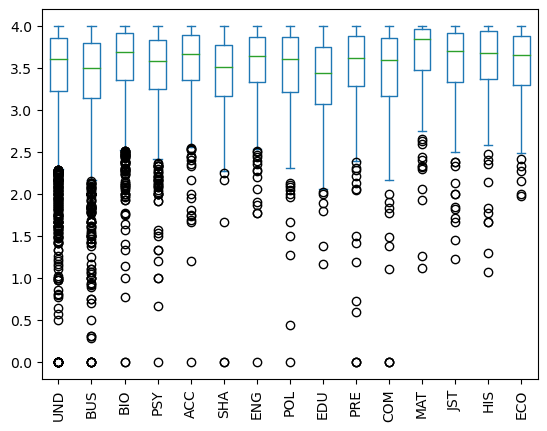

In [57]:
# Get a list of popular majors
popmajors=df.Major.value_counts()[:15].index
# We make a table of GPA with each major getting its own column
gpamatrix=df.pivot(columns='Major',values='gpa_first_term')
# Let's make a boxplot of the GPA for each major
gpamatrix[popmajors].plot(kind='box', rot=90)

So, some majors seem to be from students with higher GPA and some with lower. But mostly there's a lot of overlap.

Having created the SAT / ACT feature, we have two continuous variables: GPA and SAT_ACT. Likely they are correlated. Let's see:

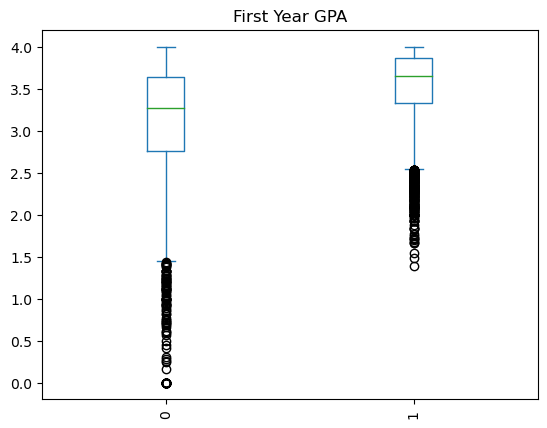

In [58]:
gpamatrix2=df.pivot(columns='completed',values='gpa_first_year')
# Let's make a boxplot of the first year GPA, by completed [0,1] 
plot1=gpamatrix2.plot(kind='box', rot=90)
plot1.set_title('First Year GPA')
plt.show()

<Axes: xlabel='sat_act', ylabel='gpa_first_term'>

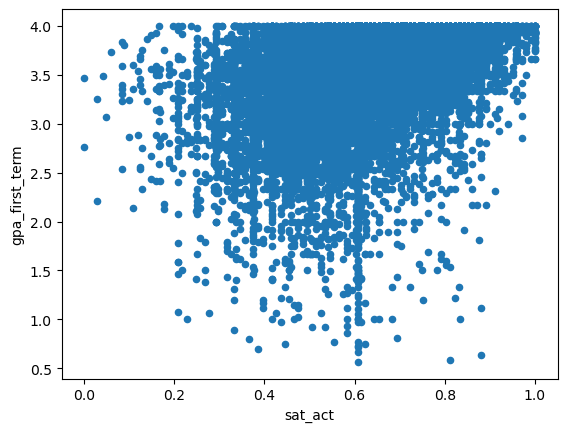

In [59]:
# No significant data for GPA below .5
df[df.gpa_first_term>.5].plot.scatter(x='sat_act', y='gpa_first_term')

Very hard to discern anything in the blob. Let's try a hex bin plot:

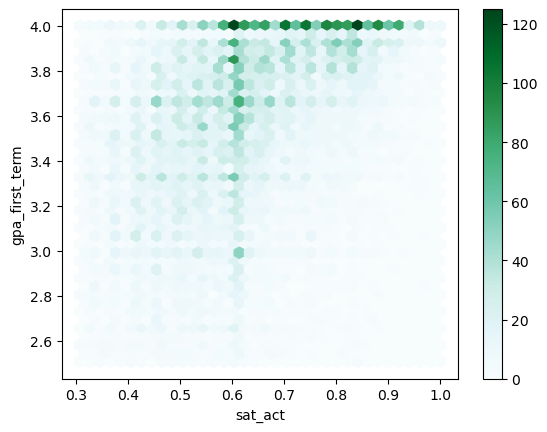

In [61]:
# focus on the main range of values, and choose a grid size by experimenting:
df[(df.gpa_first_term>2.5) & (df.sat_act >.3)].plot.hexbin(x='sat_act', y='gpa_first_term', gridsize=35)
plt.show()

Maybe that looks like a correlation. Interestingly, there is a vertical lineoid intensity at sat_act of about .6 Presumably, that's where the artificial scores were all populated with the mean. 

After getting the data cleaned up enough to work with, the biggest issue now is that all those string fields are useless! So we need to convert the string fields like major and ethnicity state to numbers.  
There are at least two entirely different ways to try this: By converting them to dummy variables; or to encode them to numerical categoricals. Let's try both, and maybe one will be clearly superior.

Let's look for correlations:

In [62]:
df.corr(numeric_only=True)

,Gender,completed,grantpct,transfer,gpa_final,gpa_first_term,gpa_first_year,hsgpa,minor,maj2,pop_city,foreign,sat_act,pophscity
Gender,1.000000,0.108313,-0.017123,0.061853,0.156361,0.080630,0.102424,0.164014,0.059445,0.033591,0.001879,-0.038497,-0.130756,0.003641
completed,0.108313,1.000000,0.074539,-0.008660,0.434558,0.321172,0.358804,0.178067,0.017505,0.006567,0.059014,-0.021036,0.086589,0.098091
grantpct,-0.017123,0.074539,1.000000,-0.043106,0.110399,0.090858,0.096635,0.162354,-0.013958,0.001628,-0.079686,0.133244,0.191957,-0.063073
transfer,0.061853,-0.008660,-0.043106,1.000000,-0.050893,-0.045965,-0.047987,-0.058668,0.031177,0.003919,-0.060491,0.084784,-0.053527,-0.105744
gpa_final,0.156361,0.434558,0.110399,-0.050893,1.000000,0.832004,0.898541,0.434520,0.017487,0.034672,0.084508,-0.050845,0.345546,0.113709
gpa_first_term,0.080630,0.321172,0.090858,-0.045965,0.832004,1.000000,0.936382,0.392567,0.021693,0.035644,0.077038,-0.035541,0.357783,0.101525
gpa_first_year,0.102424,0.358804,0.096635,-0.047987,0.898541,0.936382,1.000000,0.407915,0.020424,0.037256,0.081880,-0.041877,0.358222,0.110558
hsgpa,0.164014,0.178067,0.162354,-0.058668,0.434520,0.392567,0.407915,1.000000,0.014487,0.042003,0.054748,-0.153083,0.428983,0.013141
minor,0.059445,0.017505,-0.013958,0.031177,0.017487,0.021693,0.020424,0.014487,1.000000,0.033723,-0.021935,0.005708,-0.003932,-0.021827
maj2,0.033591,0.006567,0.001628,0.003919,0.034672,0.035644,0.037256,0.042003,0.033723,1.000000,0.016601,0.001278,0.037331,-0.007118


Now we need to examine the GPA values:

In [63]:
df.gpa_final.isnull().sum()

14

In [64]:
gpaftmean=df.gpa_first_term.mean()
df['gpa_first_term']=df['gpa_first_term'].fillna(gpaftmean)
gpafymean=df.gpa_first_year.mean()
df['gpa_first_year']=df['gpa_first_year'].fillna(gpafymean)


In [65]:
ssc=MinMaxScaler()
gft=np.reshape(df['gpa_first_term'].values, (-1,1))
gfy=np.reshape(df['gpa_first_year'].values, (-1,1))
gpaftsc=ssc.fit_transform(gft)
gpafysc=ssc.fit_transform(gfy)
df['gpa_first_term']=gpaftsc
df['gpa_first_year']=gpafysc

In [66]:
df['gpa_first_term'].describe()

count    15657.000000
mean         0.866336
std          0.133139
min          0.000000
25%          0.808333
50%          0.900000
75%          0.964286
max          1.000000
Name: gpa_first_term, dtype: float64

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15657 entries, 0 to 15656
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          15657 non-null  int64  
 1   Major           15657 non-null  object 
 2   completed       15657 non-null  int64  
 3   grantpct        15657 non-null  int64  
 4   transfer        15657 non-null  int64  
 5   gpa_final       15643 non-null  float64
 6   gpa_first_term  15657 non-null  float64
 7   gpa_first_year  15657 non-null  float64
 8   statapp         15657 non-null  object 
 9   hsstate         15657 non-null  object 
 10  hsgpa           15657 non-null  float64
 11  minor           15657 non-null  int64  
 12  maj2            15657 non-null  int64  
 13  ethnicity       15657 non-null  object 
 14  pop_city        15657 non-null  int32  
 15  foreign         15657 non-null  int32  
 16  sat_act         15657 non-null  float64
 17  pophscity       15657 non-null 

In [68]:
df.grantpct.describe()

count    15657.000000
mean        45.092994
std         34.872659
min          0.000000
25%          5.000000
50%         46.000000
75%         75.000000
max        137.000000
Name: grantpct, dtype: float64

In [69]:
grnt=MinMaxScaler()
grntpct=np.reshape(df['grantpct'].values, (-1,1))
grntsc=ssc.fit_transform(grntpct)
df['grantpct']=grntsc


In [70]:
df=df.drop(columns=['gpa_final','gpa_first_term'])

Why drop the final GPA? Because after running this the first time, it yielded 100% accuracy- so clearly something in the target variable was present in the feature set! Of course, since the target variable is graduate- 1 or 0, then including the graduated GPA implies graduate=1! For the analysis, we need to exclude any information not known at the beginning of their schooling. Anyway we don't want to include info not available at the end of the first year.

In [50]:
df.Major.value_counts().index.values

array(['UND', 'BUS', 'BIO', 'PSY', 'ACC', 'SHA', 'ENG', 'POL', 'EDU',
       'PRE', 'COM', 'MAT', 'JST', 'HIS', 'ECO', 'SPAU', 'CHE', 'MAN',
       'PHY', 'PHI', 'SOC', 'JED', 'BUND', 'BC', 'MUS', 'SCW', 'PRH',
       'JUD', 'MED', 'ART', 'LAW', 'BIOL', 'PSC', 'NONE', 'BFIN', 'SCI',
       'SOWK', 'ENGI', 'PHT', 'CLA', 'SPE', 'SPED', 'MEDS', 'BPHM',
       'STAT', 'OCCT', 'RAB', 'JRN', 'ELED', 'BIB', 'JHI', 'LING', 'SPP'],
      dtype=object)

Too many majors. Consolidate!

In [71]:
popmajor=df.Major.value_counts()[df.Major.value_counts().values>100].index.values
df.loc[(~df['Major'].isin(popmajor)) ,'Major' ]='MISC'

In [72]:
df.Major.value_counts().index.values

array(['UND', 'BUS', 'BIO', 'PSY', 'ACC', 'MISC', 'SHA', 'ENG', 'POL',
       'EDU', 'PRE', 'COM', 'MAT', 'JST', 'HIS', 'ECO', 'SPAU', 'CHE',
       'MAN'], dtype=object)

At this point, all the fields are numerical, both for the dummy variable approach and the nominal approach.  
Upon reflection, the choice of looking at the target variable as "COMPLETED" with 0 meaning dropped out, or the target variable as "DROPOUT" with 1 meaning dropped out, is arbitrary, but presumably we are looking for dropouts and not successes. So we change the target values to their opposites.

In [73]:
dropout=1-df.completed
df['dropout']=dropout
df=df.drop(columns=['completed'])

In [74]:
df2=df 
# to experiment with

Let's look at labeling and dummying

In [75]:
df=pd.get_dummies(df)
print(df.shape)
df.head()

(15657, 74)


,Gender,grantpct,transfer,gpa_first_year,hsgpa,minor,maj2,pop_city,foreign,sat_act,...,hsstate_Unknown Nation,ethnicity_1. Non Resident Alien,ethnicity_2. Unknown,ethnicity_3. Hispanic,ethnicity_4. American Indian or Alaskan Native,ethnicity_5. Asian,ethnicity_6. Black or African American,ethnicity_7. Native Hawaiian and Other Pacific Islander,ethnicity_8. White,ethnicity_9. Two or more races
0,1,0.218978,0,0.919271,0.893273,0,0,0,0,0.732673,...,0,0,0,0,0,0,0,0,1,0
1,2,0.233577,1,0.958333,0.853909,0,0,1,0,0.584158,...,0,0,0,0,0,0,0,0,1,0
2,1,0.000000,0,0.947917,0.790636,0,0,1,0,0.583333,...,0,0,0,0,0,0,0,0,1,0
3,2,0.000000,0,0.916667,0.855545,0,0,1,0,0.613861,...,0,0,0,0,0,0,0,0,1,0
4,2,0.109489,0,0.712121,0.758455,0,0,0,0,0.375000,...,0,0,0,0,0,0,0,0,1,0


Finished with the dummy variables; now trying labeling on the copy set

In [76]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

eapp=le.fit_transform(df2.Major)
df2['Major']=eapp

eeth=le.fit_transform(df2.ethnicity)
df2['ethnicity']=eeth

est=le.fit_transform(df2.statapp)
df2['statapp']=est

ehst=le.fit_transform(df2.hsstate)
df2['hsstate']=ehst


In [77]:
df2.shape

(15657, 16)

In [78]:
df.shape

(15657, 74)

Now, finally, we can analyze!  
First split into train and test sets.

In [79]:
X=df.drop(columns=['dropout'])
y=df.dropout

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Which model to choose? For the classification maybe the random forest classifier is most forgiving to non-standardized data.

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics  
from sklearn.feature_selection import SelectFromModel

In [82]:
clf = RandomForestClassifier(n_estimators = 100)  
f=SelectFromModel(clf)  
f.fit(X_train, y_train)
  
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
  

    
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("Recall ", metrics.recall_score(y_test,y_pred))
print("F1 score ",metrics.f1_score(y_test,y_pred))
print("overall report \n", metrics.classification_report(y_test,y_pred))
print("confusion matrix \n",metrics.confusion_matrix(y_test,y_pred))

ACCURACY OF THE MODEL:  0.8106641123882503
Recall  0.22590361445783133
F1 score  0.335946248600224
overall report 
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      2468
           1       0.66      0.23      0.34       664

    accuracy                           0.81      3132
   macro avg       0.74      0.60      0.61      3132
weighted avg       0.79      0.81      0.77      3132

confusion matrix 
 [[2389   79]
 [ 514  150]]


What are the main features?

In [83]:
rf_feat_imp=f.get_support()
print(X_train.columns[rf_feat_imp])

Index(['Gender', 'grantpct', 'transfer', 'gpa_first_year', 'hsgpa', 'pop_city',
       'sat_act', 'Major_BUS', 'Major_UND'],
      dtype='object')


This is very discouraging. The model accuracy is only about 82%, when the baseline is about 80%. Comparable accuracy would be achieved by predicting that nobody would drop out!  
Even worse, the statistic we really care about is probably not accuracy but recall. We want to find all the dropouts even if we get some false positives. The recall value is only about 23% (150/664). Perhaps the other encoding method will be better.

Still, which features figures most into the model?

In [84]:
feature_imp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

gpa_first_year                                             2.407983e-01
hsgpa                                                      1.491993e-01
sat_act                                                    1.336272e-01
grantpct                                                   1.161373e-01
Gender                                                     1.994977e-02
                                                               ...     
statapp_MO                                                 8.661306e-04
ethnicity_4. American Indian or Alaskan Native             4.720364e-04
ethnicity_6. Black or African American                     3.350676e-04
ethnicity_5. Asian                                         3.142248e-04
ethnicity_7. Native Hawaiian and Other Pacific Islander    2.361454e-07
Length: 73, dtype: float64

Not surprisingly, first year GPA is the best predictor and HS gpa and SAT/ACT scores are the next predictors.

In case the better encoding is with dummy variables, let's see if that affects the model

In [85]:
X2=df2.drop(columns=['dropout'])
y2=df2.dropout

In [86]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2)

In [87]:
clf2 = RandomForestClassifier(n_estimators = 100)  
f2=SelectFromModel(clf2)  
f2.fit(X2_train, y2_train)
  
clf2.fit(X2_train, y2_train)
  
y2_pred = clf2.predict(X2_test)
  
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y2_test, y2_pred))
print("Recall ", metrics.recall_score(y2_test,y2_pred))
print("F1 score ", metrics.f1_score(y2_test,y2_pred))
print("confusion matrix \n",metrics.confusion_matrix(y2_test,y2_pred))

ACCURACY OF THE MODEL:  0.8151340996168582
Recall  0.2217125382262997
F1 score  0.333716915995397
confusion matrix 
 [[2408   70]
 [ 509  145]]


In [88]:
rf_feat2_imp=f2.get_support()
print(X2_train.columns[rf_feat2_imp])
feature_imp2 = pd.Series(clf2.feature_importances_, index = X2.columns).sort_values(ascending = False)
feature_imp2[:10]

Index(['Major', 'grantpct', 'gpa_first_year', 'hsgpa', 'sat_act'], dtype='object')


gpa_first_year    0.265419
hsgpa             0.166538
sat_act           0.148413
grantpct          0.126602
Major             0.076162
statapp           0.060299
hsstate           0.056701
Gender            0.019110
ethnicity         0.017032
pop_city          0.016719
dtype: float64

At this point we cannot rule out the possibility that the known data regarding the student at the time of enrollment may be sufficient to predict failure to a satisfactory degree of reliability; however we have been unable to design the model to execute it. Likewise, we have been unable to predict the final GPA from the initial conditions.

How could the model be improved? Several ways suggest themselves. Possibly better feature engineering would be effective; possibly a different classifier would do better. Perhaps using a logistic regression would be better here, since we can adjust the threshhold of probability to flag failure and success.

Let's try another model- KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [90]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [91]:
import warnings
warnings.filterwarnings("ignore")
y_pred2=knn.predict(X_test)

In [92]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred2))
print("Recall ", metrics.recall_score(y_test,y_pred2))
print("F1 score ",metrics.f1_score(y_test,y_pred2))
print("confusion matrix \n",metrics.confusion_matrix(y_test,y_pred2))

ACCURACY OF THE MODEL:  0.7761813537675607
Recall  0.18674698795180722
F1 score  0.2613277133825079
confusion matrix 
 [[2307  161]
 [ 540  124]]


Since that was no better, let's try the logistic regression

In [93]:
from sklearn.linear_model import LogisticRegression
clf5=LogisticRegression(max_iter=200)
clf5.fit(X_train,y_train)
clf5.score(X_test,y_test)

0.814176245210728

In [94]:
y_pred6=(clf5.predict_proba(X_test)[:,1]>.5).astype(int)

In [95]:
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred6))
print("Recall ", metrics.recall_score(y_test,y_pred6))
print("F1 score ",metrics.f1_score(y_test,y_pred6))
print("confusion matrix \n",metrics.confusion_matrix(y_test,y_pred6))

ACCURACY OF THE MODEL:  0.814176245210728
Recall  0.21385542168674698
F1 score  0.3279445727482679
confusion matrix 
 [[2408   60]
 [ 522  142]]


encoded categoricals

In [96]:
clf5.fit(X2_train,y2_train)
clf5.score(X2_test,y2_test)

0.8087484035759898

Let's try to adjust the threshold to improve the predictions

In [97]:
y2_pred6=(clf5.predict_proba(X2_test)[:,1]>.26).astype(int)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y2_test, y2_pred6))
print("Recall ", metrics.recall_score(y2_test,y2_pred6))
print("F1 score ",metrics.f1_score(y2_test,y2_pred6))
print("confusion matrix \n",metrics.confusion_matrix(y2_test,y2_pred6))

ACCURACY OF THE MODEL:  0.7611749680715197
Recall  0.4877675840978593
F1 score  0.46031746031746035
confusion matrix 
 [[2065  413]
 [ 335  319]]


Let's adjust the cutoff probability

In [98]:
clf7=LogisticRegression(max_iter=200)
clf7.fit(X_train,y_train)
clf7.score(X_test,y_test)
y_pred7=(clf7.predict_proba(X_test)[:,1]>.5).astype(int)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred7))
print("Recall ", metrics.recall_score(y_test,y_pred7))
print("F1 score ",metrics.f1_score(y_test,y_pred7))
print("confusion matrix \n",metrics.confusion_matrix(y_test,y_pred7))

ACCURACY OF THE MODEL:  0.814176245210728
Recall  0.21385542168674698
F1 score  0.3279445727482679
confusion matrix 
 [[2408   60]
 [ 522  142]]


well, recall goes up, but the cost in false positives is too high. So no success with logistic regression either, beyond the 82%.